In [1]:
#!pip install dask[dataframe]
!pip install tpot
!pip install xgboost

<b>Data loading</b>

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import tpot
import glob
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

seed = 42

<b>Loading experiment data</b>

In [3]:
path = 'data/procedura'
all_files = glob.glob(path + '/*[0-9].txt')

dataframes = []

len(all_files)
for path in all_files:
    with open(path) as f:
        dataframes.append(pd.read_csv(f, sep = '\t', names = [
            'PersonID',
            'StimulusID',
            'Consistency',
            'Condition',
            'Sound',
            'Image',
            'Widget',
            'Answer',
            'TimeToAnswer',
            'StimulusTimestamp'
        ],usecols = [
            'Sound',
            'Image',
            'Answer'
        ]))
        
df = pd.concat(dataframes)

<b>Preprocessing experiment data</b>

In [4]:
def extractValence(answer):
    return (float(answer.split(',')[0][1:])+1)*5
    
valenceCol = [extractValence(x) for x in df['Answer']]

def extractArousal(answer):
    return (float(answer.split(',')[1][:-1])+1)*5

arousalCol = [extractArousal(x) for x in df['Answer']]

def isEroticImage(imageId):
    if imageId >= 4001 and imageId <= 5000:
        return 1
    else:
        return 0
    
eroticImageCol = [isEroticImage(x) for x in df['Image']]

def isEroticSound(soundId):
    if soundId >= 200 and soundId <= 216:
        return 1
    else:
        return 0
    
eroticSoundCol = [isEroticSound(x) for x in df['Sound']]

#https://stackoverflow.com/questions/12555323/adding-new-column-to-existing-dataframe-in-python-pandas
#https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
df = df.assign(ResearchValence=valenceCol)
df = df.assign(ResearchArousal=arousalCol)
df = df.assign(EroticImage=eroticImageCol)
df = df.assign(EroticSound=eroticSoundCol)

del df['Answer']
df.head()

,Sound,Image,ResearchValence,ResearchArousal,EroticImage,EroticSound
0,170,1112,5.002399,0.449335,0,0
1,373,9402,0.521854,4.978546,0,0
2,353,4660,8.317368,1.667026,1,0
3,277,3053,1.877277,8.310184,0,0
4,360,4656,9.509720,5.055283,1,0


<b>Load images and sounds<b>

In [5]:
dfImages = pd.read_csv('./data/IAPS.csv', # w pliku wszystke przecinki zamienione na kropki
                                  sep=';', 
                                  decimal=",",
                                  usecols=['IAPS', 'ValenceMean', 'ArousalMean'])
dfImages.IAPS = dfImages.IAPS.astype(int)
print('ImageValenceMean min: ' + str(dfImages['ValenceMean'].min()))
print('ImageValenceMean max: ' + str(dfImages['ValenceMean'].max()))
print('ImageArousalMean min: ' + str(dfImages['ArousalMean'].min()))
print('ImageArousalMean max: ' + str(dfImages['ArousalMean'].max()))
dfImages.head()

ImageValenceMean min: 1.31
ImageValenceMean max: 8.34
ImageArousalMean min: 1.72
ImageArousalMean max: 7.35


,IAPS,ValenceMean,ArousalMean
0,1019,3.95,5.77
1,1022,4.26,6.02
2,1026,4.09,5.61
3,1030,4.30,5.46
4,1033,3.87,6.13


In [6]:
dfSounds  = pd.read_csv('./data/IADS2.csv', 
                                  sep=';', 
                                  usecols=['Number', 'ValenceMean', 'ArousalMean'])

print('SoundValenceMean min: ' + str(dfSounds['ValenceMean'].min()))
print('SoundValenceMean max: ' + str(dfSounds['ValenceMean'].max()))
print('SoundArousalMean min: ' + str(dfSounds['ArousalMean'].min()))
print('SoundArousalMean max: ' + str(dfSounds['ArousalMean'].max()))
dfSounds.head()

SoundValenceMean min: 1.57
SoundValenceMean max: 7.9
SoundArousalMean min: 2.88
SoundArousalMean max: 8.16


,Number,ValenceMean,ArousalMean
0,102,4.63,4.91
1,104,4.96,5.37
2,105,2.88,6.40
3,106,3.37,6.39
4,107,5.47,5.85


<b>Creating a single dataframe</b>

In [7]:
def extractImageValenceMean(imageId):
    currentDf = dfImages[dfImages['IAPS']==imageId]
    if len(currentDf) != 0:
        return currentDf.iloc[0]['ValenceMean']
    
imageValenceMeanCol = [extractImageValenceMean(x) for x in df['Image']]

In [8]:
def extractImageArousalMean(imageId):
    currentDf = dfImages[dfImages['IAPS']==imageId]
    if len(currentDf) != 0:
        return currentDf.iloc[0]['ArousalMean']
    
imageArousalMeanCol = [extractImageArousalMean(x) for x in df['Image']]

In [9]:
def extractSoundValenceMean(soundId):
    currentDf = dfSounds[dfSounds['Number']==soundId]
    if len(currentDf) != 0:
        return currentDf.iloc[0]['ValenceMean']

soundValenceMeanCol = [extractSoundValenceMean(x) for x in df['Sound']]

In [10]:
def extractSoundArousalMean(soundId):
    currentDf = dfSounds[dfSounds['Number']==soundId]
    if len(currentDf) != 0:
        return currentDf.iloc[0]['ArousalMean']

soundArousalMeanCol = [extractSoundArousalMean(x) for x in df['Sound']]

In [11]:
df = df.assign(ImageValenceMean=imageValenceMeanCol)
df = df.assign(ImageArousalMean=imageArousalMeanCol)
df = df.assign(SoundValenceMean=soundValenceMeanCol)
df = df.assign(SoundArousalMean=soundArousalMeanCol)

del df['Sound']
del df['Image']

df.head()

,ResearchValence,ResearchArousal,EroticImage,EroticSound,ImageValenceMean,ImageArousalMean,SoundValenceMean,SoundArousalMean
0,5.002399,0.449335,0,0,4.71,4.60,5.31,4.60
1,0.521854,4.978546,0,0,4.48,5.07,5.09,4.65
2,8.317368,1.667026,1,0,7.40,6.58,7.38,6.62
3,1.877277,8.310184,0,0,1.31,6.91,1.63,7.79
4,9.509720,5.055283,1,0,6.73,6.41,6.94,7.54


In [12]:
#Podsumowanie połaczonego dataframe
df.describe(include='all')

,ResearchValence,ResearchArousal,EroticImage,EroticSound,ImageValenceMean,ImageArousalMean,SoundValenceMean,SoundArousalMean
count,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,4.454911,5.425000,0.164652,0.103846,4.517778,6.022269,4.864084,6.374817
std,2.538182,2.298985,0.370900,0.305089,2.201454,0.801469,1.941345,0.894736
min,0.000000,0.000000,0.000000,0.000000,1.310000,3.770000,1.630000,3.930000
25%,2.116026,4.114746,0.000000,0.000000,2.460000,5.670000,3.050000,5.890000
50%,4.796292,5.442619,0.000000,0.000000,4.470000,6.210000,5.090000,6.550000
75%,6.032511,7.081730,0.000000,0.000000,6.730000,6.580000,6.770000,6.980000
max,10.000000,10.000000,1.000000,1.000000,7.770000,7.350000,7.900000,7.990000


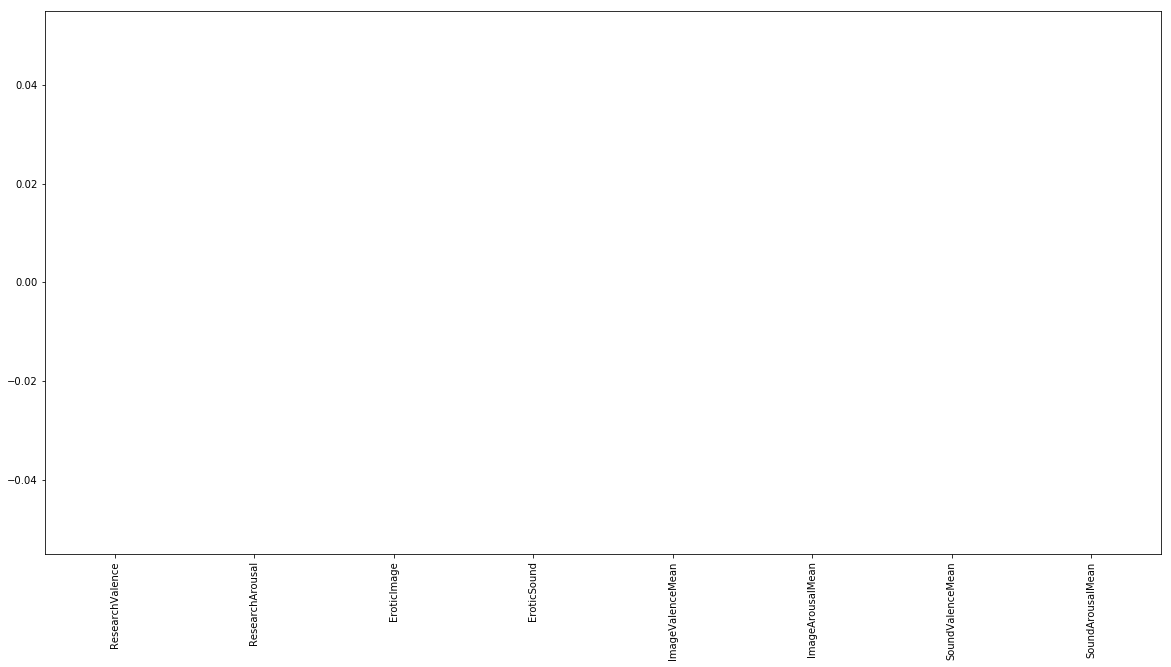

In [13]:
#Sprawdzam ile brakuje
df.isnull().sum().to_frame(name='count').sort_values(by='count', ascending=False)['count'].plot(kind='bar', figsize=(20,10))

Nie brakuje nic, wszystkie dane są poprawne, brak dziur

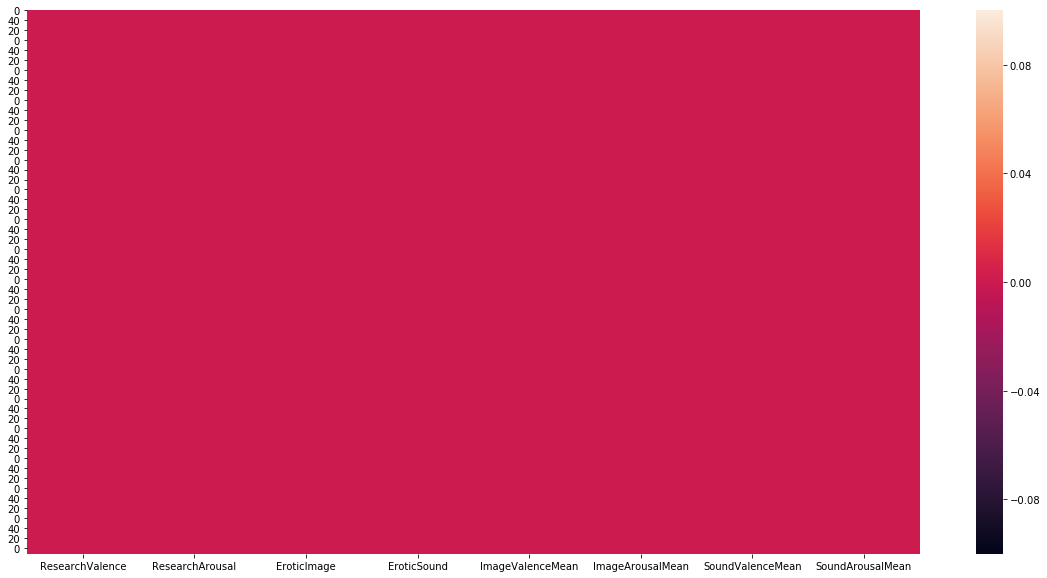

In [14]:
plt.figure(figsize=(20, 10))
sns.heatmap(df.isnull())

Dane pełne

In [15]:
df.count()

ResearchValence     5460
ResearchArousal     5460
EroticImage         5460
EroticSound         5460
ImageValenceMean    5460
ImageArousalMean    5460
SoundValenceMean    5460
SoundArousalMean    5460
dtype: int64

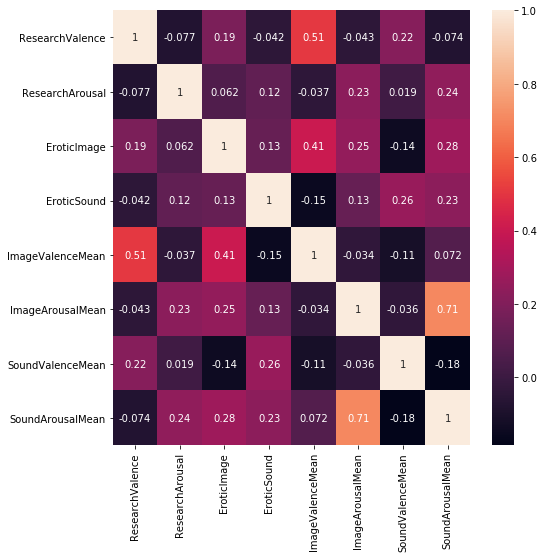

In [16]:
corr = df.corr(method='pearson')
plt.subplots(figsize=(8,8))
sns.heatmap(corr, annot=True)

In [17]:
df.describe()

,ResearchValence,ResearchArousal,EroticImage,EroticSound,ImageValenceMean,ImageArousalMean,SoundValenceMean,SoundArousalMean
count,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000,5460.000000
mean,4.454911,5.425000,0.164652,0.103846,4.517778,6.022269,4.864084,6.374817
std,2.538182,2.298985,0.370900,0.305089,2.201454,0.801469,1.941345,0.894736
min,0.000000,0.000000,0.000000,0.000000,1.310000,3.770000,1.630000,3.930000
25%,2.116026,4.114746,0.000000,0.000000,2.460000,5.670000,3.050000,5.890000
50%,4.796292,5.442619,0.000000,0.000000,4.470000,6.210000,5.090000,6.550000
75%,6.032511,7.081730,0.000000,0.000000,6.730000,6.580000,6.770000,6.980000
max,10.000000,10.000000,1.000000,1.000000,7.770000,7.350000,7.900000,7.990000


<h2>Automatic pipeline with TPOTRegressor</h2>

In [18]:
from sklearn.model_selection import train_test_split

X = df[['EroticImage','EroticSound','ImageValenceMean','ImageArousalMean','SoundValenceMean','SoundArousalMean']].values
y = df['ResearchArousal'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [19]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(
    n_jobs = -1,
    random_state = seed,
    scoring = 'neg_mean_squared_error')
tpot.fit(X_train, Y_train)
tpot.score(X_test, Y_test)

[02:15:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:15:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[02:21:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:21:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[02:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:30:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:31:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[02:38:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:38:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[02:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[02:48:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[02:52:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:52:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[02:55:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:55:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:55:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:55:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:55:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:55:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:55:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[02:58:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:58:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:59:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[03:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:01:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:01:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:01:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[03:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:04:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:04:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:04:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:04:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:04:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:05:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

-4.657842967448062

In [50]:
tpot.export('tpot_optimized_pipeline_arousal.py') #tu przez przypadek nadpisałem plik ;_; znalazło jakiś ExtraTreesRegressor

In [52]:
y = df['ResearchValence'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

tpot = TPOTRegressor(
    n_jobs = -1,
    random_state = seed,
    scoring = 'neg_mean_squared_error',
    verbosity = 1)
tpot.fit(X_train, Y_train)
valence_test_error = tpot.score(X_test, Y_test)
tpot.export('tpot_optimized_pipeline_valence.py')

#valence
#==================================================
#arousal

X = df[['EroticImage','EroticSound','ImageValenceMean','ImageArousalMean','SoundValenceMean','SoundArousalMean']].values
y = df['ResearchArousal'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

tpot = TPOTRegressor(
    n_jobs = -1,
    random_state = seed,
    scoring = 'neg_mean_squared_error')
tpot.fit(X_train, Y_train)
arousal_test_error = tpot.score(X_test, Y_test)
tpot.export('tpot_optimized_pipeline_arousal.py')


[04:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:36:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:36:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:36:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:41:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:42:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:45:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:45:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:46:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:48:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:49:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:52:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:52:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:53:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:53:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:53:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:53:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:54:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:54:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:55:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:56:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:57:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[04:59:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:59:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:02:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:11:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:11:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:13:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:13:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:13:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:14:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:16:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:18:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:20:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:20:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:21:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:23:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:23:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:24:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:24:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:26:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:27:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:28:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:30:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:31:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:32:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:32:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:35:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:36:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:41:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:41:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:42:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:42:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:45:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:45:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:48:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:48:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:50:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:50:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:53:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:53:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:54:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[05:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:57:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[06:00:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:00:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[06:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[06:07:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:07:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[06:18:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:18:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:19:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[06:30:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best pipeline: ElasticNetCV(XGBRegressor(LinearSVR(SelectFwe(input_matrix, alpha=0.04), C=0.0001, dual=True, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.001), learning_rate=0.01, max_depth=6, min_child_weight=9, n_estimators=100, nthread=1, subsample=0.9500000000000001), l1_ratio=0.05, tol=0.1)
[06:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:30:59] WARNING: /workspace/src/objective/regression_ob

[06:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:35:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:35:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:35:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:36:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[06:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:44:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:45:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:45:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:45:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[06:52:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:53:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[06:58:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:58:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:58:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:58:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:58:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:58:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:58:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[07:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:03:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[07:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[07:10:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:11:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:11:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:11:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[07:13:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:13:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:14:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:14:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:14:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:14:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[07:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:16:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:16:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:16:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:16:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:16:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:16:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:16:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[07:19:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:19:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [53]:
print(valence_test_error, arousal_test_error)

-4.054647924190241 -4.657842967448062


<h2>Shallow neural net with keras and tensorflow</h2>

In [25]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [26]:
model = Sequential()
model.add(Dense(12, input_dim=6, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                84        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

Instructions for updating:
Use tf.cast instead.


In [34]:
X_train_NN, X_dev_NN, Y_train_NN, Y_dev_NN = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)


history = model.fit(X_train, Y_train, epochs=150, verbose=1, validation_data = (X_dev_NN, Y_dev_NN))

Train on 4368 samples, validate on 874 samples
Epoch 1/150
4368/4368 [==============================] - 0s 69us/sample - loss: 4.0566 - mean_squared_error: 4.0566 - mean_absolute_error: 1.5621 - val_loss: 3.9241 - val_mean_squared_error: 3.9241 - val_mean_absolute_error: 1.5449
Epoch 2/150
4368/4368 [==============================] - 0s 71us/sample - loss: 4.0586 - mean_squared_error: 4.0586 - mean_absolute_error: 1.5640 - val_loss: 3.9217 - val_mean_squared_error: 3.9217 - val_mean_absolute_error: 1.5382
Epoch 3/150
4368/4368 [==============================] - 0s 70us/sample - loss: 4.0541 - mean_squared_error: 4.0541 - mean_absolute_error: 1.5602 - val_loss: 3.9178 - val_mean_squared_error: 3.9178 - val_mean_absolute_error: 1.5374
Epoch 4/150
4368/4368 [==============================] - 0s 69us/sample - loss: 4.0503 - mean_squared_error: 4.0503 - mean_absolute_error: 1.5582 - val_loss: 3.9251 - val_mean_squared_error: 3.9251 - val_mean_absolute_error: 1.5386
Epoch 5/150
4368/4368 [==

Epoch 36/150
4368/4368 [==============================] - 0s 76us/sample - loss: 4.0383 - mean_squared_error: 4.0383 - mean_absolute_error: 1.5576 - val_loss: 3.8726 - val_mean_squared_error: 3.8726 - val_mean_absolute_error: 1.5303
Epoch 37/150
4368/4368 [==============================] - 0s 74us/sample - loss: 4.0319 - mean_squared_error: 4.0319 - mean_absolute_error: 1.5534 - val_loss: 3.8780 - val_mean_squared_error: 3.8779 - val_mean_absolute_error: 1.5319
Epoch 38/150
4368/4368 [==============================] - 0s 75us/sample - loss: 4.0316 - mean_squared_error: 4.0316 - mean_absolute_error: 1.5556 - val_loss: 3.8982 - val_mean_squared_error: 3.8982 - val_mean_absolute_error: 1.5429
Epoch 39/150
4368/4368 [==============================] - 0s 73us/sample - loss: 4.0265 - mean_squared_error: 4.0265 - mean_absolute_error: 1.5549 - val_loss: 3.8691 - val_mean_squared_error: 3.8691 - val_mean_absolute_error: 1.5288
Epoch 40/150
4368/4368 [==============================] - 0s 78us/sa

4368/4368 [==============================] - 0s 64us/sample - loss: 3.9857 - mean_squared_error: 3.9857 - mean_absolute_error: 1.5415 - val_loss: 3.8551 - val_mean_squared_error: 3.8551 - val_mean_absolute_error: 1.5301
Epoch 107/150
4368/4368 [==============================] - 0s 62us/sample - loss: 3.9967 - mean_squared_error: 3.9967 - mean_absolute_error: 1.5443 - val_loss: 3.8674 - val_mean_squared_error: 3.8674 - val_mean_absolute_error: 1.5235
Epoch 108/150
4368/4368 [==============================] - 0s 63us/sample - loss: 3.9999 - mean_squared_error: 3.9999 - mean_absolute_error: 1.5468 - val_loss: 3.8492 - val_mean_squared_error: 3.8492 - val_mean_absolute_error: 1.5257
Epoch 109/150
4368/4368 [==============================] - 0s 61us/sample - loss: 3.9903 - mean_squared_error: 3.9903 - mean_absolute_error: 1.5438 - val_loss: 3.8297 - val_mean_squared_error: 3.8297 - val_mean_absolute_error: 1.5182
Epoch 110/150
4368/4368 [==============================] - 0s 58us/sample - lo

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


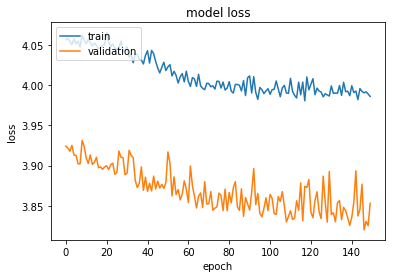

In [36]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

* both losses seem to be lowering over time - could probably use more epochs
* both losses are jumping erratically - LR smaller then default could help
* dev set loss is lower then training loss - either the model is underfitting the data (could use more layers or neurons in hidden layers) or something's wrong

<h2>Valence with NN take 2</h2>

In [56]:
model = Sequential()
model.add(Dense(32, input_dim=6, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_10 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 1,433
Trainable params: 1,433
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

y = df['ResearchValence'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train_NN, X_dev_NN, Y_train_NN, Y_dev_NN = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

history = model.fit(X_train, Y_train, epochs=150, verbose=1, validation_data = (X_dev_NN, Y_dev_NN))



Train on 4368 samples, validate on 874 samples
Epoch 1/150
4368/4368 [==============================] - 1s 158us/sample - loss: 4.4966 - mean_squared_error: 4.4966 - mean_absolute_error: 1.6839 - val_loss: 4.1382 - val_mean_squared_error: 4.1382 - val_mean_absolute_error: 1.5947
Epoch 2/150
4368/4368 [==============================] - 0s 98us/sample - loss: 4.1743 - mean_squared_error: 4.1743 - mean_absolute_error: 1.5938 - val_loss: 3.9363 - val_mean_squared_error: 3.9363 - val_mean_absolute_error: 1.5500
Epoch 3/150
4368/4368 [==============================] - 0s 99us/sample - loss: 4.1376 - mean_squared_error: 4.1376 - mean_absolute_error: 1.5797 - val_loss: 4.0170 - val_mean_squared_error: 4.0170 - val_mean_absolute_error: 1.5784
Epoch 4/150
4368/4368 [==============================] - 0s 101us/sample - loss: 4.1548 - mean_squared_error: 4.1548 - mean_absolute_error: 1.5853 - val_loss: 3.8982 - val_mean_squared_error: 3.8982 - val_mean_absolute_error: 1.5408
Epoch 5/150
4368/4368 [

Epoch 36/150
4368/4368 [==============================] - 0s 97us/sample - loss: 4.0090 - mean_squared_error: 4.0090 - mean_absolute_error: 1.5458 - val_loss: 3.8715 - val_mean_squared_error: 3.8715 - val_mean_absolute_error: 1.5299
Epoch 37/150
4368/4368 [==============================] - 0s 99us/sample - loss: 4.0359 - mean_squared_error: 4.0359 - mean_absolute_error: 1.5492 - val_loss: 3.8656 - val_mean_squared_error: 3.8656 - val_mean_absolute_error: 1.5299
Epoch 38/150
4368/4368 [==============================] - 0s 97us/sample - loss: 4.0140 - mean_squared_error: 4.0140 - mean_absolute_error: 1.5461 - val_loss: 3.8510 - val_mean_squared_error: 3.8510 - val_mean_absolute_error: 1.5171
Epoch 39/150
4368/4368 [==============================] - 0s 98us/sample - loss: 4.0119 - mean_squared_error: 4.0119 - mean_absolute_error: 1.5451 - val_loss: 3.8380 - val_mean_squared_error: 3.8380 - val_mean_absolute_error: 1.5138
Epoch 40/150
4368/4368 [==============================] - 0s 98us/sa

4368/4368 [==============================] - 0s 94us/sample - loss: 3.9892 - mean_squared_error: 3.9892 - mean_absolute_error: 1.5439 - val_loss: 3.8996 - val_mean_squared_error: 3.8996 - val_mean_absolute_error: 1.5429
Epoch 72/150
4368/4368 [==============================] - 0s 98us/sample - loss: 3.9966 - mean_squared_error: 3.9966 - mean_absolute_error: 1.5456 - val_loss: 3.8301 - val_mean_squared_error: 3.8301 - val_mean_absolute_error: 1.5119
Epoch 73/150
4368/4368 [==============================] - 0s 95us/sample - loss: 3.9753 - mean_squared_error: 3.9753 - mean_absolute_error: 1.5365 - val_loss: 3.8498 - val_mean_squared_error: 3.8498 - val_mean_absolute_error: 1.5118
Epoch 74/150
4368/4368 [==============================] - 0s 93us/sample - loss: 3.9977 - mean_squared_error: 3.9977 - mean_absolute_error: 1.5427 - val_loss: 3.8323 - val_mean_squared_error: 3.8323 - val_mean_absolute_error: 1.5161
Epoch 75/150
4368/4368 [==============================] - 0s 93us/sample - loss: 

4368/4368 [==============================] - 0s 92us/sample - loss: 3.9430 - mean_squared_error: 3.9430 - mean_absolute_error: 1.5321 - val_loss: 3.7974 - val_mean_squared_error: 3.7974 - val_mean_absolute_error: 1.5071
Epoch 107/150
4368/4368 [==============================] - 0s 97us/sample - loss: 3.9363 - mean_squared_error: 3.9363 - mean_absolute_error: 1.5313 - val_loss: 3.8537 - val_mean_squared_error: 3.8537 - val_mean_absolute_error: 1.5116
Epoch 108/150
4368/4368 [==============================] - 0s 94us/sample - loss: 3.9260 - mean_squared_error: 3.9260 - mean_absolute_error: 1.5264 - val_loss: 3.9689 - val_mean_squared_error: 3.9689 - val_mean_absolute_error: 1.5347
Epoch 109/150
4368/4368 [==============================] - 0s 91us/sample - loss: 3.9292 - mean_squared_error: 3.9292 - mean_absolute_error: 1.5301 - val_loss: 3.7830 - val_mean_squared_error: 3.7830 - val_mean_absolute_error: 1.5015
Epoch 110/150
4368/4368 [==============================] - 0s 90us/sample - lo

4368/4368 [==============================] - 0s 95us/sample - loss: 3.9202 - mean_squared_error: 3.9202 - mean_absolute_error: 1.5225 - val_loss: 3.7685 - val_mean_squared_error: 3.7685 - val_mean_absolute_error: 1.5037
Epoch 142/150
4368/4368 [==============================] - 0s 99us/sample - loss: 3.9195 - mean_squared_error: 3.9195 - mean_absolute_error: 1.5268 - val_loss: 3.7546 - val_mean_squared_error: 3.7546 - val_mean_absolute_error: 1.4913
Epoch 143/150
4368/4368 [==============================] - 0s 100us/sample - loss: 3.9096 - mean_squared_error: 3.9096 - mean_absolute_error: 1.5251 - val_loss: 3.7557 - val_mean_squared_error: 3.7557 - val_mean_absolute_error: 1.4959
Epoch 144/150
4368/4368 [==============================] - 0s 95us/sample - loss: 3.8718 - mean_squared_error: 3.8718 - mean_absolute_error: 1.5153 - val_loss: 3.7632 - val_mean_squared_error: 3.7632 - val_mean_absolute_error: 1.5057
Epoch 145/150
4368/4368 [==============================] - 0s 94us/sample - l

In [58]:
score = model.evaluate(X_test, Y_test)

1092/1092 [==============================] - 0s 34us/sample - loss: 4.3576 - mean_squared_error: 4.3576 - mean_absolute_error: 1.6503


<h2>Arousal with NN</h2>

In [38]:
y = df['ResearchArousal'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train_NN, X_dev_NN, Y_train_NN, Y_dev_NN = train_test_split(X_train, Y_train, test_size=0.2, random_state=seed)

In [40]:
model = Sequential()
model.add(Dense(18, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 18)                126       
_________________________________________________________________
dense_6 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 52        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 411
Trainable params: 411
Non-trainable params: 0
_________________________________________________________________


In [41]:
from keras.optimizers import Adam

model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [43]:
history = model.fit(X_train, Y_train, epochs=150, verbose=1, validation_data = (X_dev_NN, Y_dev_NN))

Train on 4368 samples, validate on 874 samples
Epoch 1/150
4368/4368 [==============================] - 1s 128us/sample - loss: 37.7262 - mean_squared_error: 37.7262 - mean_absolute_error: 5.5856 - val_loss: 20.9725 - val_mean_squared_error: 20.9725 - val_mean_absolute_error: 4.0773
Epoch 2/150
4368/4368 [==============================] - 0s 76us/sample - loss: 8.4886 - mean_squared_error: 8.4886 - mean_absolute_error: 2.3366 - val_loss: 4.9866 - val_mean_squared_error: 4.9866 - val_mean_absolute_error: 1.7511
Epoch 3/150
4368/4368 [==============================] - 0s 86us/sample - loss: 5.1009 - mean_squared_error: 5.1009 - mean_absolute_error: 1.7918 - val_loss: 4.8385 - val_mean_squared_error: 4.8385 - val_mean_absolute_error: 1.7276
Epoch 4/150
4368/4368 [==============================] - 0s 88us/sample - loss: 5.0027 - mean_squared_error: 5.0027 - mean_absolute_error: 1.7732 - val_loss: 4.7855 - val_mean_squared_error: 4.7855 - val_mean_absolute_error: 1.7221
Epoch 5/150
4368/436

Epoch 36/150
4368/4368 [==============================] - 0s 68us/sample - loss: 4.8955 - mean_squared_error: 4.8955 - mean_absolute_error: 1.7469 - val_loss: 4.7131 - val_mean_squared_error: 4.7131 - val_mean_absolute_error: 1.7093
Epoch 37/150
4368/4368 [==============================] - 0s 67us/sample - loss: 4.9006 - mean_squared_error: 4.9006 - mean_absolute_error: 1.7511 - val_loss: 4.7362 - val_mean_squared_error: 4.7362 - val_mean_absolute_error: 1.7224
Epoch 38/150
4368/4368 [==============================] - 0s 68us/sample - loss: 4.9074 - mean_squared_error: 4.9074 - mean_absolute_error: 1.7505 - val_loss: 4.7131 - val_mean_squared_error: 4.7131 - val_mean_absolute_error: 1.7077
Epoch 39/150
4368/4368 [==============================] - 0s 68us/sample - loss: 4.9142 - mean_squared_error: 4.9142 - mean_absolute_error: 1.7500 - val_loss: 4.7177 - val_mean_squared_error: 4.7177 - val_mean_absolute_error: 1.7138
Epoch 40/150
4368/4368 [==============================] - 0s 67us/sa

4368/4368 [==============================] - 0s 79us/sample - loss: 4.8871 - mean_squared_error: 4.8871 - mean_absolute_error: 1.7434 - val_loss: 4.7257 - val_mean_squared_error: 4.7257 - val_mean_absolute_error: 1.7207
Epoch 107/150
4368/4368 [==============================] - 0s 80us/sample - loss: 4.8771 - mean_squared_error: 4.8771 - mean_absolute_error: 1.7420 - val_loss: 4.6911 - val_mean_squared_error: 4.6911 - val_mean_absolute_error: 1.7043
Epoch 108/150
4368/4368 [==============================] - 0s 77us/sample - loss: 4.8691 - mean_squared_error: 4.8691 - mean_absolute_error: 1.7403 - val_loss: 4.7529 - val_mean_squared_error: 4.7529 - val_mean_absolute_error: 1.7326
Epoch 109/150
4368/4368 [==============================] - 0s 78us/sample - loss: 4.8656 - mean_squared_error: 4.8656 - mean_absolute_error: 1.7403 - val_loss: 4.6961 - val_mean_squared_error: 4.6961 - val_mean_absolute_error: 1.7057
Epoch 110/150
4368/4368 [==============================] - 0s 75us/sample - lo

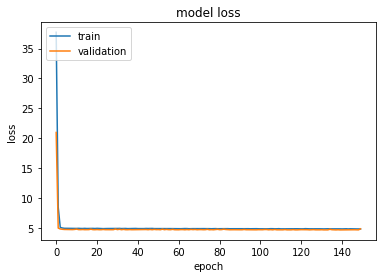

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<b>decided against lowering the learning rate since the default is 0.001</b>

<b>in this case the losses ended up being very close to each other, therefore rendering further training of the same model highly improbable to improve the situation</b>
<b>also the validation and training losses are about equal which yet again calls for more complex model</b>

In [55]:
# arousal with NN
score = model.evaluate(X_test, Y_test)

1092/1092 [==============================] - 0s 38us/sample - loss: 4.9588 - mean_squared_error: 4.9588 - mean_absolute_error: 1.7905


<h2>Wnioski</h2>
* all of the proposed NN models seem to be underfitting the data, increasing the complexity of the models by adding hidden layers and number of neurons seems to better the results though should be performed in a more structured manner
* the best models were generated by TPOT over the course of several hours of computing
* 